In [1]:
# %matplotlib widget

import json
import os
import warnings
from os.path import join
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import torch_geometric.utils as tutils
from sklearn.exceptions import UndefinedMetricWarning
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree
from tqdm import tqdm

In [2]:
def load_graphs(
    root: str,
    dataset: str,
    remove_node_attr: bool,
    use_degree: bool,
    node_attr: str = "x",
) -> Tuple[List[nx.Graph], np.ndarray]:
    """

    Args:
        root:
        dataset:
        remove_node_attr:
        use_degree:
        node_attr:

    Returns:

    """
    dataset = TUDataset(root=root, name=dataset)

    tmp_graph = dataset[0]
    is_graph_labelled = node_attr in tmp_graph.keys
    is_graph_lbl_empty = tmp_graph.x.size(1) == 0 if is_graph_labelled else True

    nx_graphs = []
    graph_labels = []
    for graph in tqdm(dataset, desc="Load Graphs"):
        if not is_graph_labelled or is_graph_lbl_empty:
            # Create graph with dummy node vector
            degrees = degree(graph.edge_index[0], graph.num_nodes)
            graph = Data(x=degrees, y=graph.y, edge_index=graph.edge_index)
        if remove_node_attr:
            if use_degree:
                degrees = degree(graph.edge_index[0], graph.num_nodes)
                graph.x = degrees
            else:
                graph.num_nodes = graph.x.shape[0]
                graph.x = torch.ones(graph.num_nodes, dtype=torch.float32)

        nx_graph = tutils.to_networkx(graph, node_attrs=[node_attr], to_undirected=True)
        nx_graphs.append(nx_graph)
        graph_labels.append(int(graph.y))

    graph_cls = np.array(graph_labels)
    return nx_graphs, graph_cls

In [3]:
datasets = [
    "COLLAB",
    "IMDB-BINARY",
    "IMDB-MULTI",
    "REDDIT-BINARY",
    "REDDIT-MULTI-5K",
    "REDDIT-MULTI-12K",
    "AIDS",
    "BZR",
    "BZR_MD",
    "COX2",
    "COX2_MD",
    "DHFR",
    "DHFR_MD",
    "ER_MD",
    "MUTAG",
    "Mutagenicity",
    "NCI1",
    "NCI109",
    "PTC_FM",
    "PTC_FR",
    "PTC_MM",
    "PTC_MR",
    "DD",
    "ENZYMES",
    "KKI",
    "OHSU",
    "Peking_1",
    "PROTEINS_full",
    "MSRC_9",
    "MSRC_21",
    "FRANKENSTEIN",
    "PROTEINS",
    "COIL-DEL",
    "COIL-RAG",
    "Letter-high",
    "Letter-low",
    "Letter-med",
]

Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4431.64it/s]


Number of graphs 2000
Max number of nodes 95
Max number of edges 103


In [140]:
def build_heatmap(graphs: List[nx.Graph], max_nodes, max_edges=None) -> np.ndarray:
    if max_edges is None:
        max_edges = max_nodes * (max_nodes - 1) // 2
    dim = (max_edges + 1, max_nodes + 1)
    heatmap = np.ones(dim, dtype=np.int32) * -100

    for graph in graphs:
        n = len(graph.nodes)
        m = len(graph.edges)

        if heatmap[m, n] < 0:
            heatmap[m, n] = 0
        heatmap[m, n] += 1
    return heatmap

In [142]:

def plot_kde(dataset, xs, ys, lbls, xmin, xmax, ymin, ymax):

    custome_palette = sns.color_palette(palette='mako', n_colors=len(set(lbls)))
    x = [x for lbl, x in zip(lbls, xs) if lbl == 0]
    y = [y for lbl, y in zip(lbls, ys) if lbl == 0]

    fig = plt.figure(figsize=(8, 8))
    g = sns.jointplot(
        x=x,
        y=y,
        palette=custome_palette[0],
        kind="kde",
        marginal_kws={"color": custome_palette[0], "alpha": 0.2},
        fill=True,
        thresh=0.05,
        alpha=0.5,
        label='0',
        ylim=(ymin,ymax),
        xlim=(xmin,xmax)
    )
    
    set_lbls = set(lbls)
    set_lbls.discard(0)
    for current_lbl in set_lbls:
        x = [x for lbl, x in zip(lbls, xs) if lbl == current_lbl]
        y = [y for lbl, y in zip(lbls, ys) if lbl == current_lbl]

        g.x = x
        g.y = y
        g.plot_joint(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05, alpha=0.9, label='1')
        ax = plt.gca()
        ax.legend()
        g.plot_marginals(sns.kdeplot, color="b", fill=True, alpha=0.9, legend=False)
        
    plt.savefig(os.path.join('plot_node_edge_distr', f'kde_{dataset}'))

In [146]:
import os

In [179]:
sns.set(style="ticks")
sns.set_theme()


In [ ]:

def min_max(val):
    val_pbot = np.percentile(val, 1)
    val_ptop = np.percentile(val, 99)
    val_pad = 0.2*(val_ptop - val_pbot)
    val_min = val_pbot - val_pad
    val_max = val_ptop + val_pad
    
    return 0, val_max


def plot_joint(dataset, x, y, lbls, xmin, xmax, ymin, ymax):
    fig = plt.figure(figsize=(8, 8))
    palette = 'Set1'

    #sns.set_palette(palette)
    g = sns.jointplot(
        x=x,
        y=y,
        hue=lbls,
        # palette=palette,
        kind="scatter",
        s=5,
       # marginal_kws=dict(grid=False),
        ylim=(ymin,ymax),
        xlim=(xmin,xmax)
    )
    g.set_axis_labels('# Nodes', '# Edges')
    g.fig.suptitle(f'{dataset}')
    sns.histplot(x=x,
                 y=y,
                 bins=500,
                 pthresh=0.1,
                 #palette=palette,
                 hue=lbls)


    plt.tight_layout()
    plt.savefig(os.path.join('plot_node_edge_distr', f'joint_{dataset}'))
    

for dataset in datasets:
    graphs, lbls = load_graphs("../data", dataset, False, False)
    max_nodes = np.max([len(graph.nodes) for graph in graphs])
    max_edges = np.max([len(graph.edges) for graph in graphs])
    print(f"Number of graphs {len(graphs)}")
    print(f"Max number of nodes {max_nodes}")
    print(f"Max number of edges {max_edges}")
    
    x = [len(graph.nodes) for graph in graphs]
    y = [len(graph.edges) for graph in graphs]
    xmin, xmax = min_max(x)
    ymin, ymax = min_max(y)
    
    plot_joint(dataset, x, y, lbls, xmin, xmax, ymin, ymax)
    # plot_kde(dataset, x, y, lbls, xmin, xmax, ymin, ymax)


Load Graphs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 109.06it/s]


Number of graphs 5000
Max number of nodes 492
Max number of edges 40119


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4133.12it/s]

Number of graphs 1000
Max number of nodes 136
Max number of edges 1249



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 4996.57it/s]


Number of graphs 1500
Max number of nodes 89
Max number of edges 1467


Load Graphs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 680.66it/s]


Number of graphs 2000
Max number of nodes 3782
Max number of edges 4071


Load Graphs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:09<00:00, 525.01it/s]


Number of graphs 4999
Max number of nodes 3648
Max number of edges 4783


Load Graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11929/11929 [00:19<00:00, 611.80it/s]


Number of graphs 11929
Max number of nodes 3782
Max number of edges 5171


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7856.69it/s]

Number of graphs 2000
Max number of nodes 95
Max number of edges 103



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:06<00:00, 66.51it/s]

Number of graphs 405
Max number of nodes 57
Max number of edges 60



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 2565.17it/s]

Number of graphs 306
Max number of nodes 33
Max number of edges 528



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 5319.70it/s]

Number of graphs 467
Max number of nodes 56
Max number of edges 59



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 2099.63it/s]
/tmp/ipykernel_14646/1316112394.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


Number of graphs 303
Max number of nodes 36
Max number of edges 630


Load Graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:01<00:00, 431.70it/s]

Number of graphs 756
Max number of nodes 71
Max number of edges 73



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 2168.43it/s]


Number of graphs 393
Max number of nodes 39
Max number of edges 741


Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 2226.06it/s]

Number of graphs 446
Max number of nodes 43
Max number of edges 903



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 5314.43it/s]

Number of graphs 188
Max number of nodes 28
Max number of edges 33



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4337/4337 [00:00<00:00, 5764.00it/s]


Number of graphs 4337
Max number of nodes 417
Max number of edges 112


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4110/4110 [00:00<00:00, 5229.91it/s]

Number of graphs 4110


Max number of nodes 111
Max number of edges 119


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4127/4127 [00:00<00:00, 5250.44it/s]

Number of graphs 4127
Max number of nodes 111
Max number of edges 119



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:00<00:00, 6797.46it/s]

Number of graphs 349
Max number of nodes 64
Max number of edges 71



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 6849.93it/s]

Number of graphs 351
Max number of nodes 64
Max number of edges 71



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 6942.78it/s]

Number of graphs 336
Max number of nodes 64
Max number of edges 71



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 6894.21it/s]

Number of graphs 344
Max number of nodes 64
Max number of edges 71



Load Graphs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [00:02<00:00, 579.12it/s]


Number of graphs 1178
Max number of nodes 5748
Max number of edges 14267


Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 5065.81it/s]

Number of graphs 600
Max number of nodes 126
Max number of edges 149



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 2002.55it/s]

Number of graphs 83
Max number of nodes 90
Max number of edges 237



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1230.94it/s]

Number of graphs 79
Max number of nodes 171
Max number of edges 823



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2083.09it/s]

Number of graphs 85
Max number of nodes 134
Max number of edges 535



Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [00:00<00:00, 4927.61it/s]

Number of graphs 1113
Max number of nodes 620
Max number of edges 1049



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 3845.16it/s]

Number of graphs 221
Max number of nodes 55
Max number of edges 145



Load Graphs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 2286.78it/s]


Number of graphs 563
Max number of nodes 141
Max number of edges 405


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4337/4337 [00:03<00:00, 1297.67it/s]


Number of graphs 4337
Max number of nodes 214
Max number of edges 217


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [00:00<00:00, 4313.58it/s]


Number of graphs 1113
Max number of nodes 620
Max number of edges 1049


Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:00<00:00, 4857.85it/s]


Number of graphs 3900
Max number of nodes 77
Max number of edges 222


/tmp/ipykernel_14646/1316112394.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_14646/1316112394.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
Load Graphs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:00<00:00, 7900.01it/s]


Number of graphs 3900
Max number of nodes 11
Max number of edges 13


400
1600


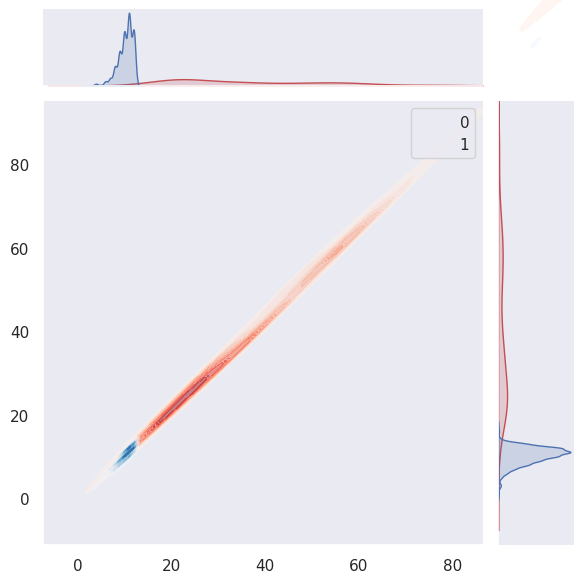

In [145]:
sns.set_theme(style="dark")
xs = [len(graph.nodes) for graph in graphs]
ys = [len(graph.edges) for graph in graphs]

x = [x for lbl, x in zip(lbls, xs) if lbl == 0]
y = [y for lbl, y in zip(lbls, ys) if lbl == 0]
print(len(x))

g = sns.jointplot(
    x=x,
    y=y,
    cmap="Reds",
    kind="kde",
    marginal_kws={"color": "r", "alpha": 0.2},
    fill=True,
    thresh=0.05,
    alpha=0.5,
    label='0',
    ylim=(ymin,ymax),
    xlim=(xmin,xmax)
)
x = [x for lbl, x in zip(lbls, xs) if lbl == 1]
y = [y for lbl, y in zip(lbls, ys) if lbl == 1]
print(len(x))

g.x = x
g.y = y
g.plot_joint(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05, alpha=0.5, label='1')
ax = plt.gca()
ax.legend()
g.plot_marginals(sns.kdeplot, color="b", fill=True, alpha=0.2, legend=False)

In [153]:
a = set(lbls).discard(0)
print(a)

None


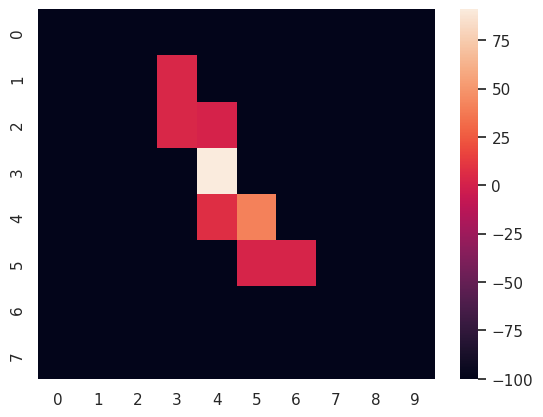

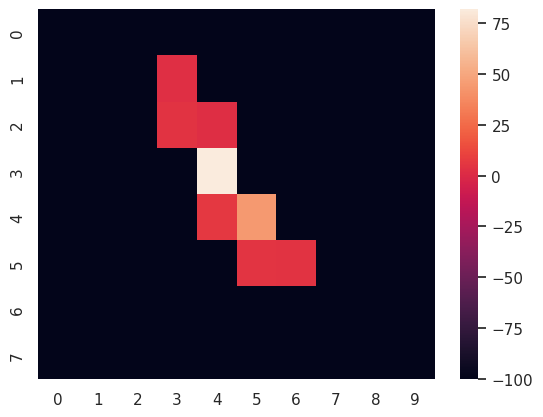

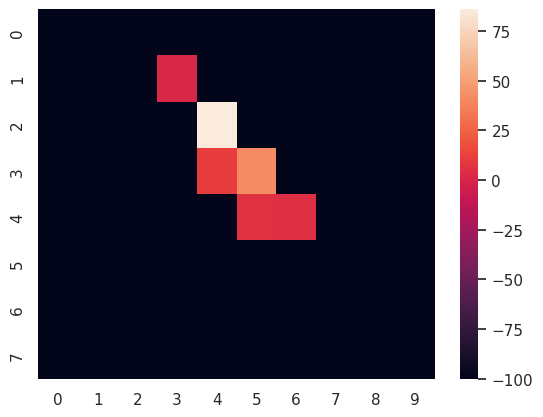

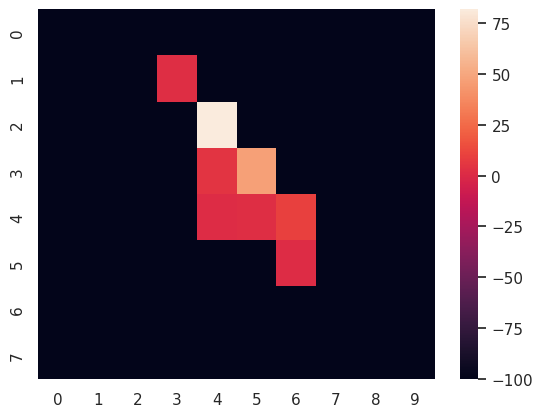

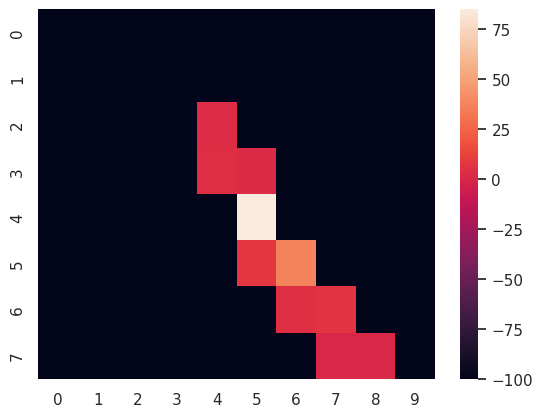

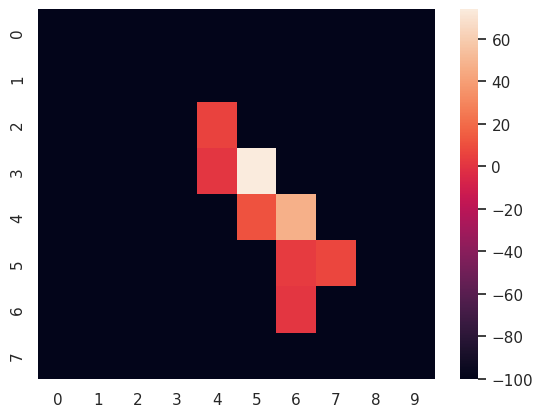

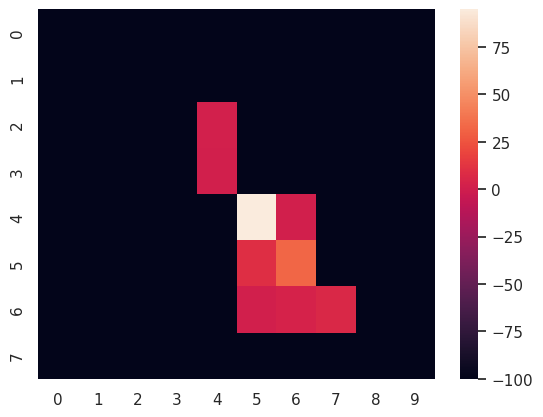

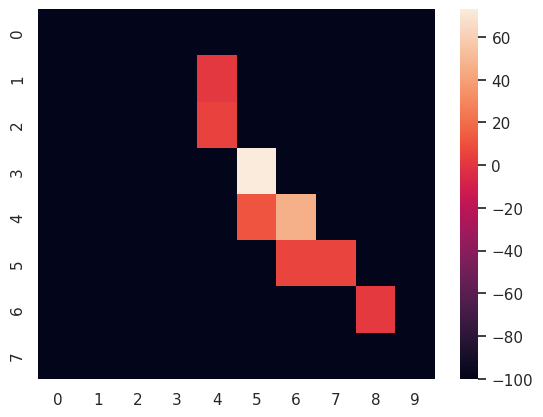

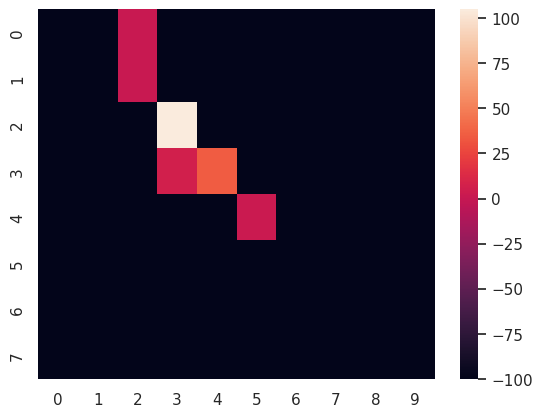

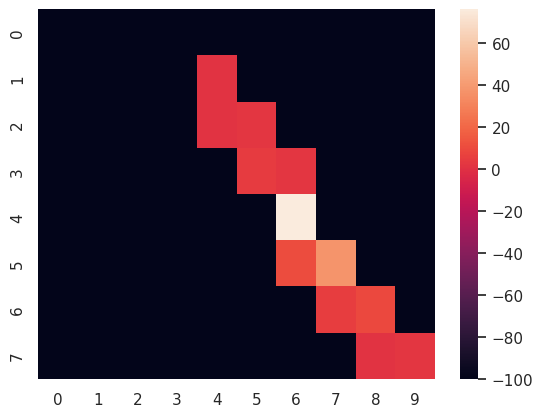

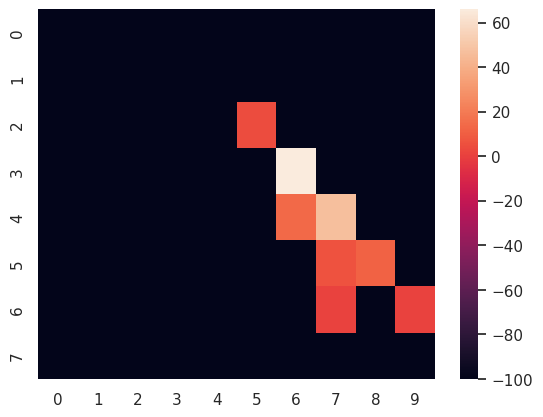

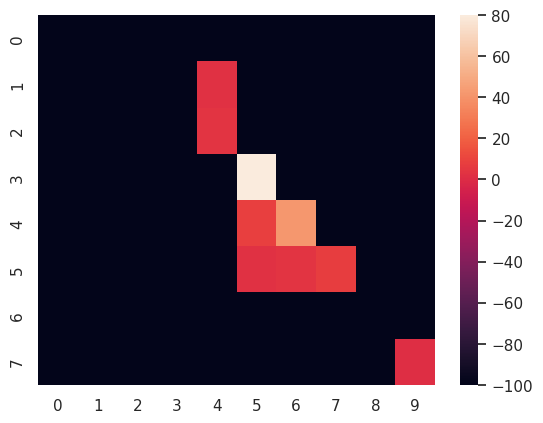

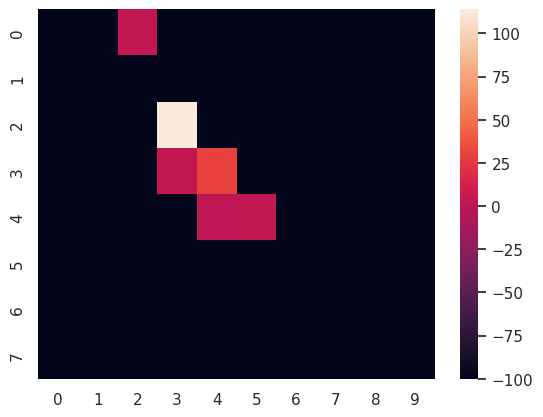

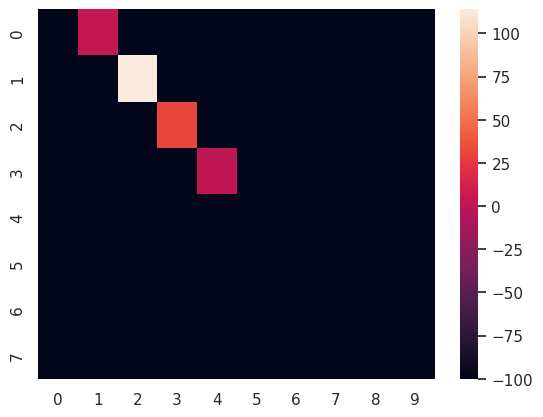

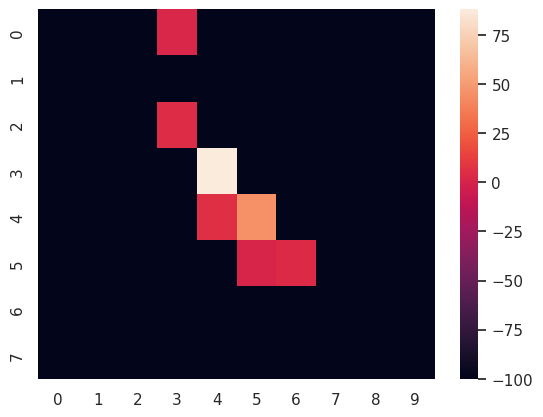

In [32]:
for cls_ in set(lbls):
    graphs_per_cls = [graph for graph, lbl in zip(graphs, lbls) if lbl == cls_]

    heatmap = build_heatmap(graphs_per_cls, max_nodes, max_edges)
    ax = sns.heatmap(heatmap[: max_edges + 1, :])
    # ax = sns.heatmap(heatmap[np.sum(heatmap, axis=1) > -49300,:], cmap='coolwarm')
    plt.show()

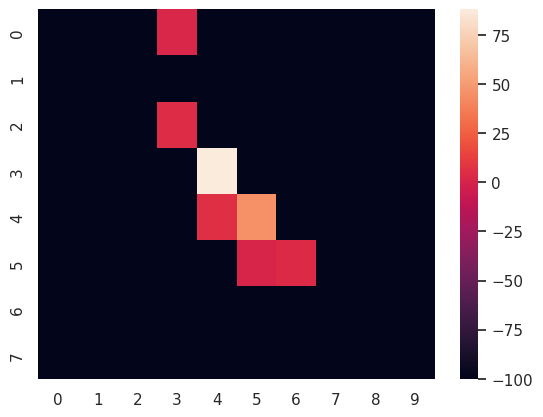

In [33]:
ax = sns.heatmap(heatmap[np.sum(heatmap, axis=1) > -49300, :])
plt.show()